In [2]:
import numpy as np 
import pandas as pd 

from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
import urllib
import requests
import json
from datetime import datetime,timedelta
import xmltodict # 결과가 xml 형식으로 반환된다. 이것을 dict 로 바꿔주는 라이브러리다

import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True) # 온라인이 아닌 상황에서 처리를 위한 명시 코드

#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# 브라우저에서 바로 그려지도록 
%matplotlib inline
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

## 코로나 공공데이터 불러오기

In [3]:
start_date = '20200101'
end_date = datetime.today().strftime("%Y%m%d")

my_api_key = 'P6ELThVVcjDdxzKGrTQlvsBqBrVUl3jUo1p%2B6yaTuOdR4Mrw%2F7UNBRnkRKlR7vBmPWs4LksNPBKxvvD4ts8LgA%3D%3D'

# 서비스 url 주소
url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson'

# 서비스에 필요한 파라미터 모음
queryParams = '?' + \
'ServiceKey=' + '{}'.format(my_api_key) + \
'&pageNo='+ '1' + \
'&numOfRows='+ '999' + \
'&startCreateDt={}&endCreateDt={}'.format(start_date, end_date)

#서비스url에 필요한 파라미터들을 붙여서 응답결과를 얻음.
result = requests.get(url + queryParams)

# 응답결과 파싱하기. ( 사용자가 원하는 형태로 변경)
# 응답 key 값이 영문화 되어 식별이 어려워 openAPI 문서를 참고하여
# replace 를 통해 결과를 한글화 했다.

result = result.content 
jsonString = json.dumps(xmltodict.parse(result), indent = 4)
jsonString = jsonString.replace('resultCode', '결과코드').replace('resultMsg', '결과메세지').replace('numOfRows', '한 페이지 결과 수').replace('pageNo', '페이지 수').replace('totalCount', '전체 결과 수').replace('seq', '게시글번호').replace('stateDt', '기준일').replace('stateTime', '기준시간').replace('decideCnt', '누적 확진자 수').replace('deathCnt', '누적 사망자 수').replace('accExamCnt', '누적 의심신고 검사자 수').replace('accDefRate', '누적 확진률').replace('createDt', '등록일시분초').replace('updateDt', '수정일시분초')
js = json.loads(jsonString)

# 파싱한 전체 결과 보기.
js_check_count = js["response"]['body']['items']['item'][0]['누적 확진자 수']
js = js["response"]['body']['items']['item']
corona_df = pd.DataFrame(js)
corona_df.head(2)

,누적 의심신고 검사자 수,등록일시분초,누적 사망자 수,누적 확진자 수,게시글번호,기준일,기준시간,수정일시분초,누적 확진률
0,19456900,2022-01-02 08:57:24.688,5694,639083,746,20220102,00:00,2022-01-02 12:57:25.935,NaN
1,19364122,2022-01-01 09:02:39.218,5625,635250,745,20220101,00:00,2022-01-02 08:57:54.231,NaN


In [4]:
corona_df.tail(2)

,누적 의심신고 검사자 수,등록일시분초,누적 사망자 수,누적 확진자 수,게시글번호,기준일,기준시간,수정일시분초,누적 확진률
711,15,2020-01-21 09:00:00.000,0,1,2,20200121,09:00,2021-10-07 10:30:51.51,6.666666667
712,4,2020-01-20 17:00:00.000,0,1,1,20200120,17:00,2021-10-07 10:30:51.51,25


> 데이터 기간: 2020년 01월 20일부터 첫 확진자가 생겼으며, 오늘(ex. 2021년 12월 26일)까지의 데이터를 가져온다.

In [5]:
corona_df.shape

(713, 9)

In [6]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   누적 의심신고 검사자 수  713 non-null    object
 1   등록일시분초         713 non-null    object
 2   누적 사망자 수       713 non-null    object
 3   누적 확진자 수       713 non-null    object
 4   게시글번호          713 non-null    object
 5   기준일            713 non-null    object
 6   기준시간           713 non-null    object
 7   수정일시분초         712 non-null    object
 8   누적 확진률         673 non-null    object
dtypes: object(9)
memory usage: 50.3+ KB


**데이터 설명**
- ```의심신고 검사자 수```: 의심환자 신고 후 검사를 진행한 건수(결과 양성(신규 확진자 수)+결과 음성+검사 중)로서 중복 검사 건수는 포함하지 않음
- ```확진율```: 확진/검사완료


In [7]:
print("누적 확진률 null값 기간: {} ~ {}".format(corona_df[corona_df['누적 확진률'].isna()]['기준일'].min(), corona_df[corona_df['누적 확진률'].isna()]['기준일'].max()))

누적 확진률 null값 기간: 20211124 ~ 20220102


> 최근 한달 간의 누적 확진률 데이터가 누락돼 있다. (20211124 ~ 20211227)

In [8]:
len(corona_df['기준일'].unique()) # 중복 일자는 없음

713

## 전처리

In [9]:
date = []
year = []
month = []
day = []

for data in corona_df['등록일시분초']:
    date.append(data.split()[0][:-3])
    year.append(data.split()[0].split('-')[0])
    month.append(data.split()[0].split('-')[1])
    day.append(data.split()[0].split('-')[2])

In [10]:
corona_df['year_month'] = date
corona_df['year'] = year
corona_df['month'] = month
corona_df['day'] = day

corona_df['year'] = corona_df['year'].astype('int64')
corona_df['month'] = corona_df['month'].astype('int64')
corona_df['day'] = corona_df['day'].astype('int64')
corona_df['누적 사망자 수'] = corona_df['누적 사망자 수'].astype('int64')
corona_df['누적 확진자 수'] = corona_df['누적 확진자 수'].astype('int64')
corona_df['누적 의심신고 검사자 수'] = corona_df['누적 의심신고 검사자 수'].astype('int64')
# corona_df['누적 확진률'] = corona_df['누적 확진률'].astype('int64')

### 신규 확진자 수 구하기

In [11]:
corona_df['신규 확진자 수'] = corona_df['누적 확진자 수'] - corona_df['누적 확진자 수'].shift(periods=-1, fill_value=0)
corona_df.head(2)

,누적 의심신고 검사자 수,등록일시분초,누적 사망자 수,누적 확진자 수,게시글번호,기준일,기준시간,수정일시분초,누적 확진률,year_month,year,month,day,신규 확진자 수
0,19456900,2022-01-02 08:57:24.688,5694,639083,746,20220102,00:00,2022-01-02 12:57:25.935,NaN,2022-01,2022,1,2,3833
1,19364122,2022-01-01 09:02:39.218,5625,635250,745,20220101,00:00,2022-01-02 08:57:54.231,NaN,2022-01,2022,1,1,4415


### 필요없는 컬럼 제거

In [12]:
drop_col = ['등록일시분초', '게시글번호', '기준시간', '수정일시분초']
corona_dropped_df = corona_df.drop(drop_col, axis=1)
corona_dropped_df.head(2)

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수
0,19456900,5694,639083,20220102,NaN,2022-01,2022,1,2,3833
1,19364122,5625,635250,20220101,NaN,2022-01,2022,1,1,4415


In [13]:
corona_dropped_df.columns

Index(['누적 의심신고 검사자 수', '누적 사망자 수', '누적 확진자 수', '기준일', '누적 확진률', 'year_month',
       'year', 'month', 'day', '신규 확진자 수'],
      dtype='object')

### 누락 데이터 확인

In [14]:
corona_dropped_df.describe()

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,year,month,day,신규 확진자 수
count,7.130000e+02,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000
mean,6.489269e+06,1318.302945,121965.460028,2020.517532,6.653576,15.852735,896.329593
std,5.736368e+06,1192.575826,146049.904502,0.505630,3.386489,8.854912,1346.578884
min,4.000000e+00,0.000000,1.000000,2020.000000,1.000000,1.000000,0.000000
25%,1.451017e+06,293.000000,13672.000000,2020.000000,4.000000,8.000000,75.000000
50%,4.751679e+06,1140.000000,69094.000000,2021.000000,7.000000,16.000000,447.000000
75%,1.080278e+07,2034.000000,164026.000000,2021.000000,10.000000,24.000000,1131.000000
max,1.945690e+07,5694.000000,639083.000000,2022.000000,12.000000,31.000000,7849.000000


> 신규 확진자 수 max == 13,658 이므로 누락 여부 확인 필요

In [15]:
corona_dropped_df.iloc[np.argmax(corona_df['신규 확진자 수'], axis=-1):].head(2)

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수
18,18298675,4456,536491,20211215,NaN,2021-12,2021,12,15,7849
19,18224740,4386,528642,20211214,NaN,2021-12,2021,12,14,5567


> 2021년 12월 11일의 데이터가 누락돼 있음.


In [16]:
corona_dropped_df.groupby(['year', 'month'])['day'].count()

year  month
2020  1        12
      2        29
      3        31
      4        30
      5        30
      6        30
      7        31
      8        31
      9        30
      10       31
      11       30
      12       31
2021  1        31
      2        28
      3        31
      4        30
      5        31
      6        30
      7        31
      8        31
      9        30
      10       31
      11       30
      12       31
2022  1         2
Name: day, dtype: int64

In [17]:
corona_dropped_df[(corona_dropped_df['year']==2020) & (corona_dropped_df['month']==5)]['day'].unique()

array([31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [18]:
corona_dropped_df[corona_dropped_df['기준일']=='20200514']

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수


In [19]:
corona_dropped_df[corona_dropped_df['기준일']=='20200513']

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수
598,695920,259,10962,20200513,1.62078005,2020-05,2020,5,13,26


> 2020년 5월 14일의 데이터가 누락돼 있음.

### 누락 데이터 대체
[2020.05.14](http://ncov.mohw.go.kr/tcmBoardView.do?contSeq=354534#)

[2021.12.11](https://www.kdca.go.kr/upload_comm/syview/doc.html?fn=163918276218500.hwp&rs=/upload_comm/docu/0015/) 

질병관리청 자료를 통해 데이터 추가

In [20]:
corona_dropped_df.columns

Index(['누적 의심신고 검사자 수', '누적 사망자 수', '누적 확진자 수', '기준일', '누적 확진률', 'year_month',
       'year', 'month', 'day', '신규 확진자 수'],
      dtype='object')

In [21]:
data = [(711484, 260, 10991, '20200514', np.nan,'2020-05', 2020, 5, 14, 29),
        (17950721+73682, 4210, 510583, '20211211', np.nan, '2021-12', 2021, 12, 11, 6977)]

In [22]:
add_df = corona_dropped_df.append(pd.DataFrame(data, columns=corona_dropped_df.columns))
add_df.sort_values(by='누적 확진자 수', inplace=True)
add_df.reset_index(drop=True, inplace=True)

In [23]:
add_df.shape

(715, 10)

### 신규 검사자, 사망자, 확진자 구하기

In [24]:
add_df.head(2)

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수
0,4,0,1,20200120,25,2020-01,2020,1,20,1
1,15,0,1,20200121,6.666666667,2020-01,2020,1,21,0


In [25]:
col_list = ['누적 의심신고 검사자 수', '누적 사망자 수', '누적 확진자 수']
for col in col_list:
    add_df['신규 {}'.format(col[-5:])] = add_df['{}'.format(col)] - add_df['{}'.format(col)].shift(periods=1, fill_value=0)

In [26]:
prep_df = add_df.drop(col_list, axis=1)
prep_df.head()

,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수,신규 검사자 수,신규 사망자 수
0,20200120,25,2020-01,2020,1,20,1,4,0
1,20200121,6.666666667,2020-01,2020,1,21,0,11,0
2,20200122,4.761904762,2020-01,2020,1,22,0,6,0
3,20200123,4,2020-01,2020,1,23,0,4,0
4,20200124,6.896551724,2020-01,2020,1,24,1,4,0


## 시각화

### 월별 확진자 수

Text(0, 0.5, '확진자 수')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


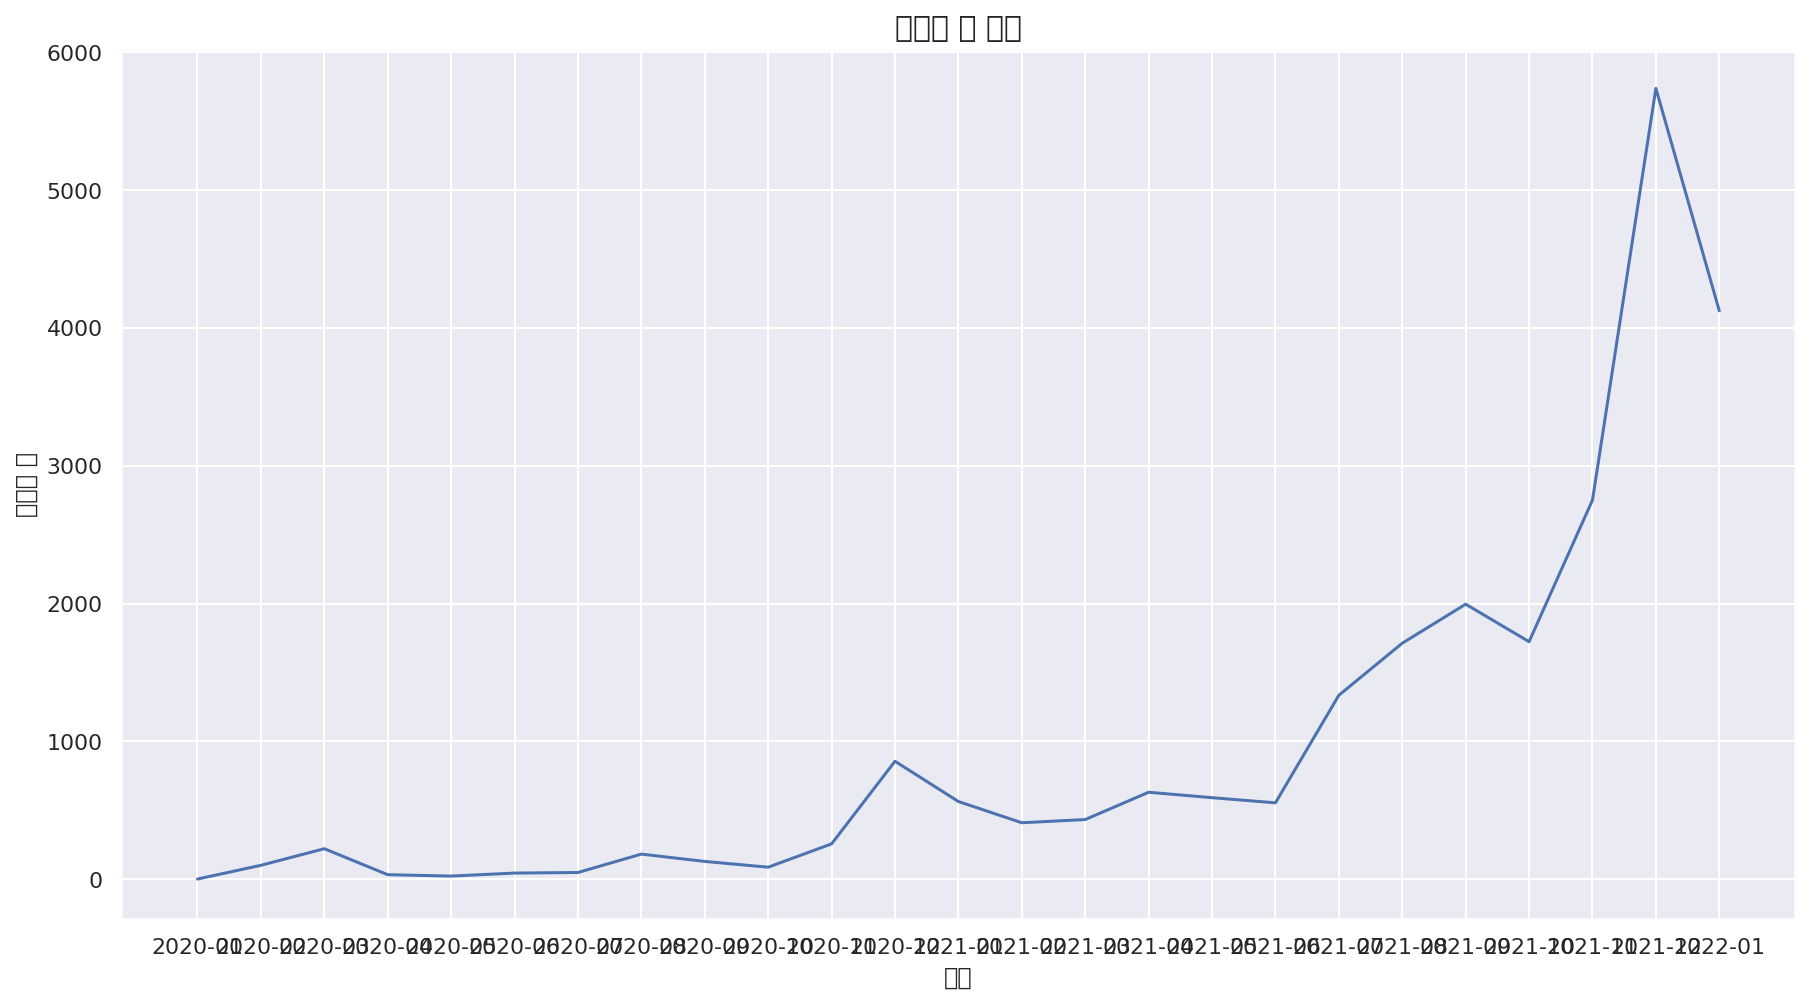

In [27]:
plt.rc('font', family='NanumBarunGothic') 

plt.figure(figsize=(15,8))

ax = sns.lineplot(prep_df["year_month"], prep_df["신규 확진자 수"], ci=None)
plt.title("확진자 수 추이", fontsize= 15)
plt.xlabel("날짜", fontsize= 12)
# plt.xticks(np.arange(0, 240, 10), labels=list(set(prep_df["year_month"])), rotation=45)
plt.ylabel("확진자 수", fontsize= 12)

In [28]:
# 데이터 변형
grp = prep_df.groupby(['year', 'month'])['신규 확진자 수'].sum()
confirmed_df = pd.DataFrame(grp).unstack().transpose()
confirmed_df = confirmed_df.droplevel(level=0)

In [29]:
confirmed_df.iplot(kind='line')

[Dash를 활용하여 Web Server 구현 방법](https://kibua20.tistory.com/212)

In [30]:
df_NFLX = pd.read_csv("./data/NFLX Historical Data.csv")
df_DIS = pd.read_csv("./data/DIS Historical Data.csv")
df_ROKU = pd.read_csv("./data/ROKU Historical Data.csv")

df_DJI = pd.read_csv("./data/Dow Jones Industrial Average Historical Data.csv")
df_SPX = pd.read_csv("./data/S&P 500 Historical Data.csv")
df_IXIC = pd.read_csv("./data/NASDAQ Composite Historical Data.csv")

df_DAL = pd.read_csv("./data/DAL Historical Data.csv")
df_UAL = pd.read_csv("./data/UAL Historical Data.csv")
df_AAL = pd.read_csv("./data/AAL Historical Data.csv")
df_RCL = pd.read_csv("./data/RCL Historical Data.csv")

In [31]:

df_NFLX = df_NFLX.loc[::-1].reset_index(drop=True)
df_DIS = df_DIS.loc[::-1].reset_index(drop=True)
df_ROKU = df_ROKU.loc[::-1].reset_index(drop=True)

df_DJI = df_DJI.loc[::-1].reset_index(drop=True)
df_SPX = df_SPX.loc[::-1].reset_index(drop=True)
df_IXIC = df_IXIC.loc[::-1].reset_index(drop=True)

df_DAL = df_DAL.loc[::-1].reset_index(drop=True)
df_UAL = df_UAL.loc[::-1].reset_index(drop=True)
df_AAL = df_AAL.loc[::-1].reset_index(drop=True)
df_RCL = df_RCL.loc[::-1].reset_index(drop=True)


<function matplotlib.pyplot.show(close=None, block=None)>

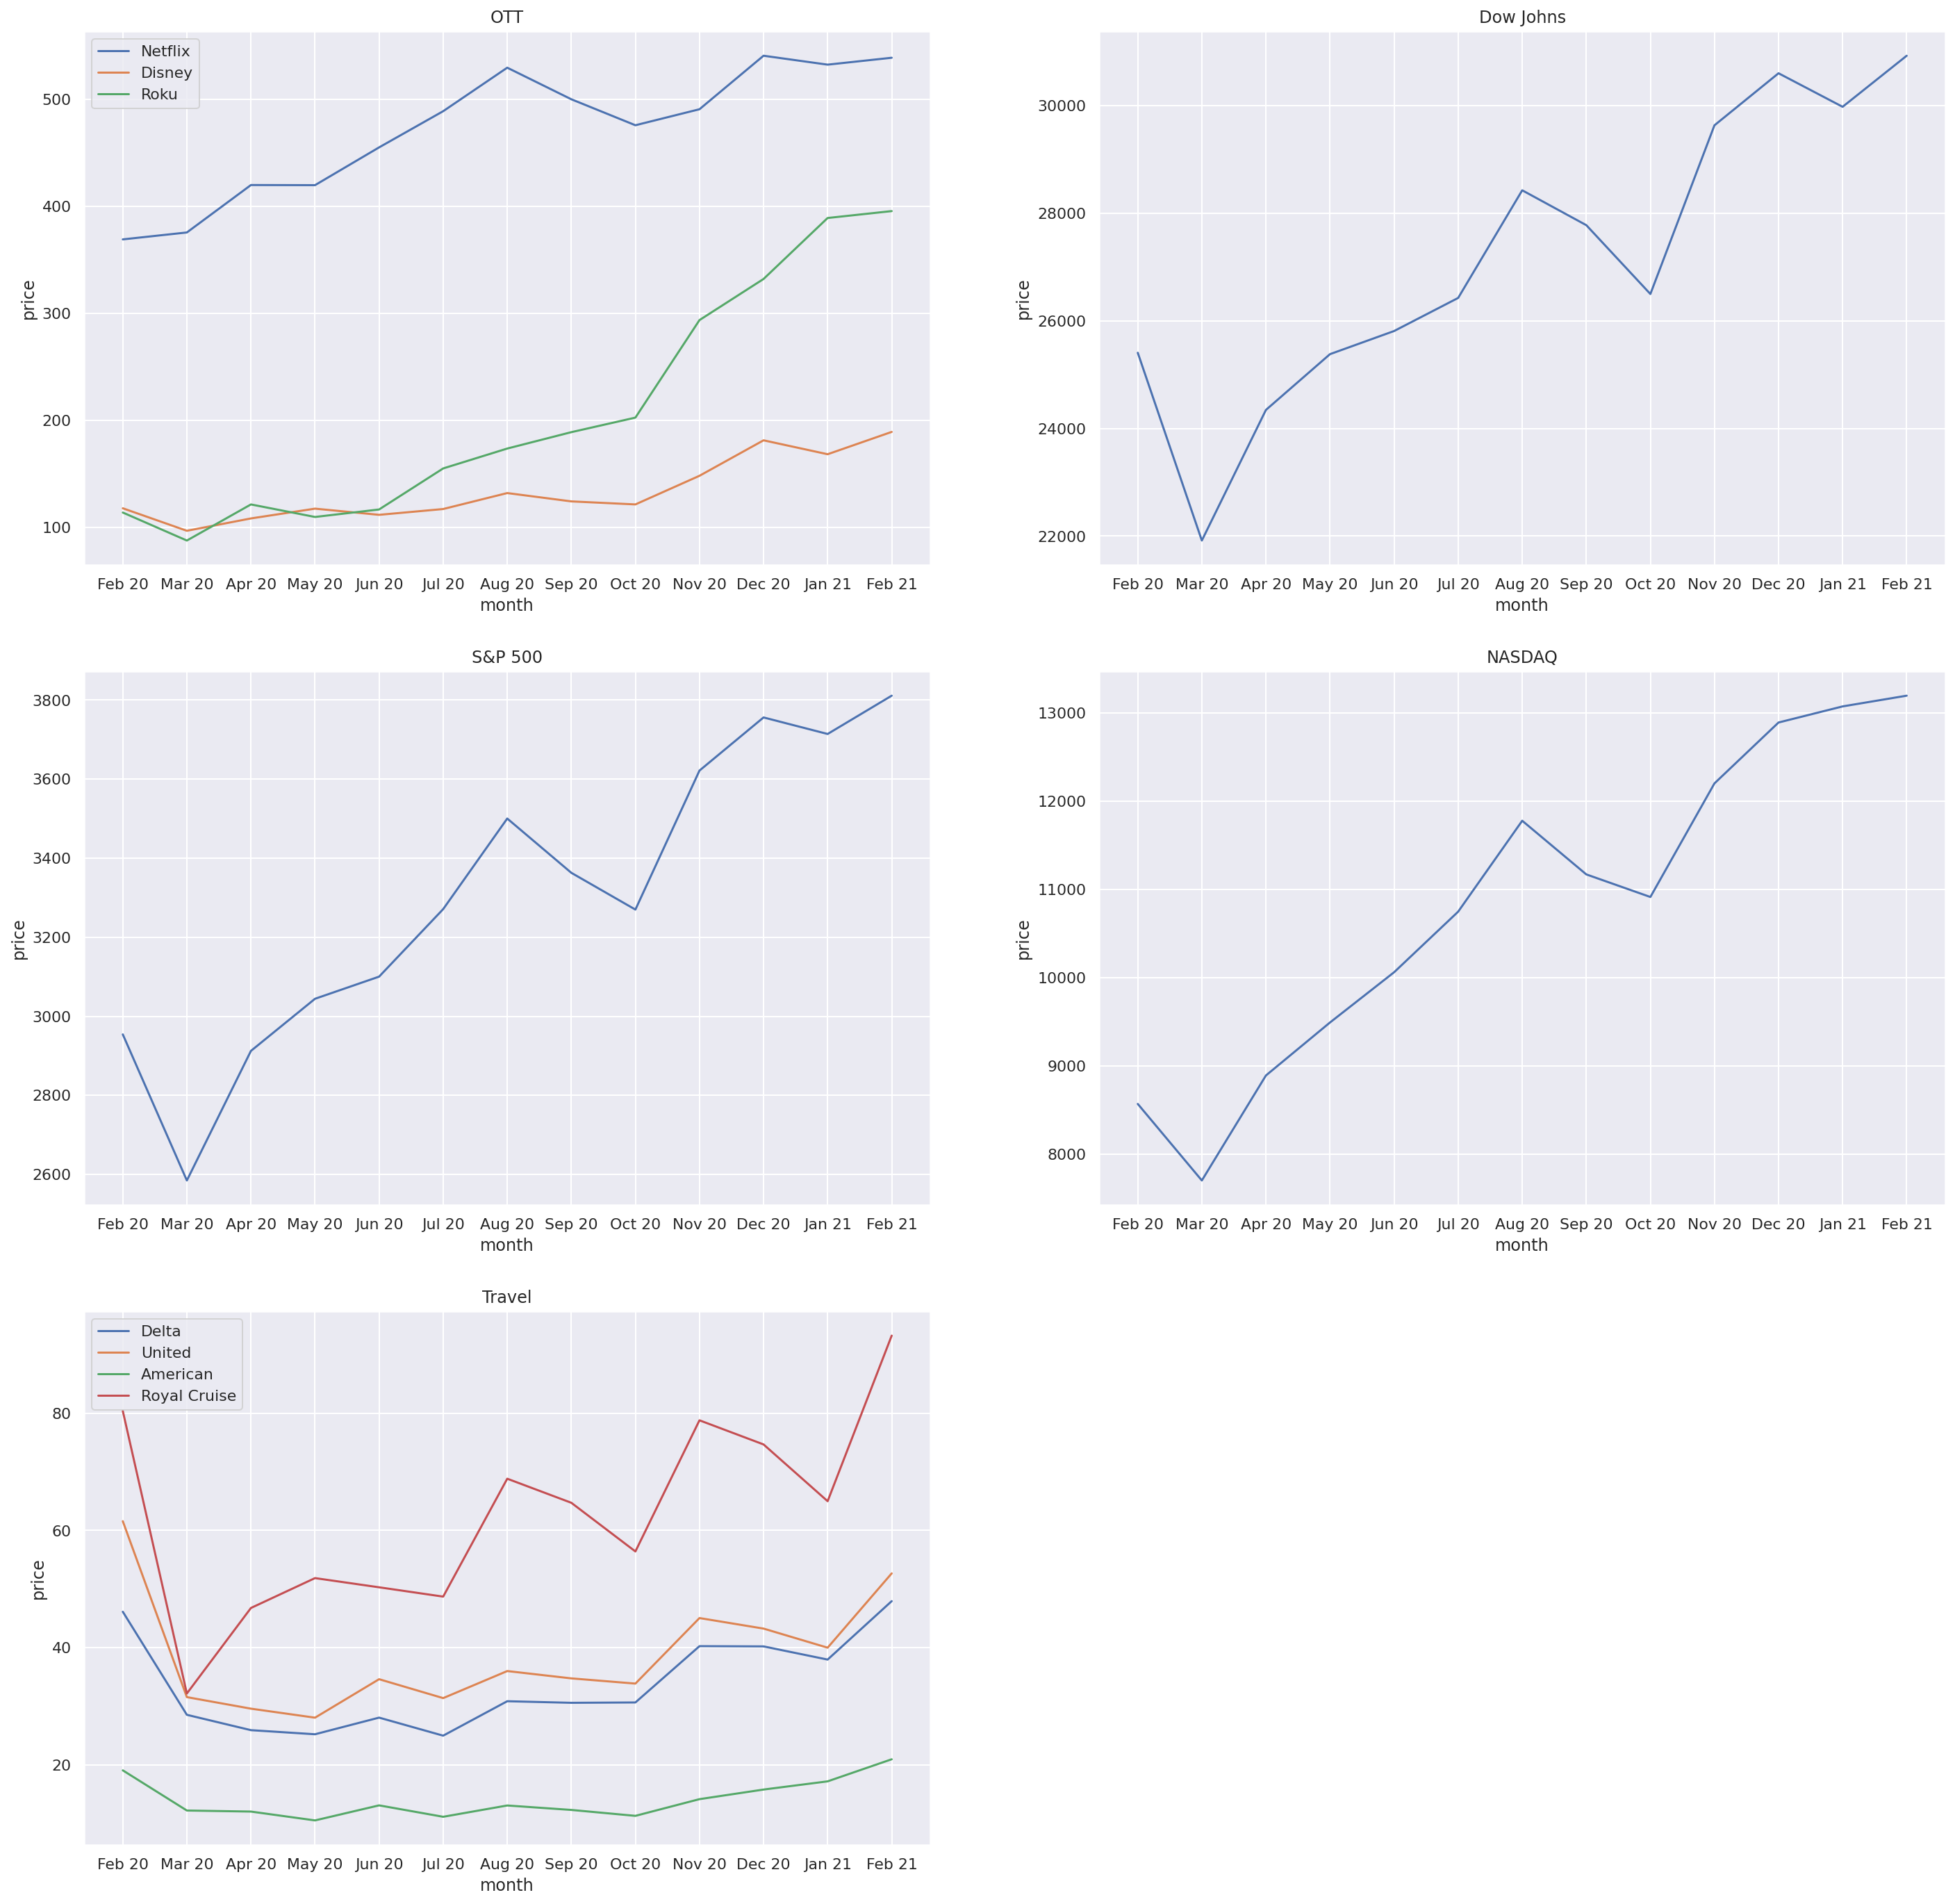

In [42]:
plt.figure(figsize=(24,24))

month = df_NFLX["Date"]
NFLX_price = df_NFLX["Price"]
DIS_price = df_DIS["Price"]
ROKU_price = df_ROKU["Price"]

DJI_price = []
SPX_price = []
IXIC_price = []

DAL_price = df_DAL["Price"]
UAL_price = df_UAL["Price"]
AAL_price = df_AAL["Price"]
RCL_price = df_RCL["Price"]

for i,j,k in zip(df_DJI["Price"], df_SPX["Price"], df_IXIC["Price"]):
    i = float(i.replace(",", ""))
    j = float(j.replace(",", ""))
    k = float(k.replace(",", ""))
    
    DJI_price.append(i)
    SPX_price.append(j)
    IXIC_price.append(k)


plt.subplot(3, 2, 1)
plt.plot(month, NFLX_price, label="Netflix")
plt.plot(month, DIS_price, label="Disney")
plt.plot(month, ROKU_price, label = "Roku")
plt.xlabel("month")
plt.ylabel("price")
plt.legend()
plt.title("OTT")

plt.subplot(3, 2, 2)
plt.plot(month, DJI_price)
plt.xlabel("month")
plt.ylabel("price")
plt.title("Dow Jones")

plt.subplot(3, 2, 3)
plt.plot(month, SPX_price)
plt.xlabel("month")
plt.ylabel("price")
plt.title("S&P 500")

plt.subplot(3, 2, 4)
plt.plot(month, IXIC_price)
plt.xlabel("month")
plt.ylabel("price")
plt.title("NASDAQ")

plt.subplot(3, 2, 5)
plt.plot(month, DAL_price, label="Delta")
plt.plot(month, UAL_price, label="United")
plt.plot(month, AAL_price, label = "American")
plt.plot(month, RCL_price, label = "Royal Cruise")
plt.xlabel("month")
plt.ylabel("price")
plt.legend()
plt.title("Travel")

plt.show


In [33]:
change_rate = lambda x: str((x[12] - x[0]) / x[0] * 100)[:5] + "%"

In [34]:
NFLX_change = change_rate(NFLX_price)
DSI_change = change_rate(DIS_price)
ROKU_change = change_rate(ROKU_price)

DJI_change = change_rate(DJI_price)
SPX_change = change_rate(SPX_price)
IXIC_change = change_rate(IXIC_price)

DAL_change = change_rate(DAL_price)
UAL_change = change_rate(UAL_price)
AAL_change = change_rate(AAL_price)
RCL_change = change_rate(RCL_price)

In [35]:
df_change_rate = pd.DataFrame({
    'ticker': ['NFLX', 'DSI', 'ROKU', 'DJI', 'SPX', 'IXIC', 'DAL', 'UAL', 'AAL', 'RCL' ],
    'rate': [NFLX_change, DSI_change, ROKU_change, DJI_change, SPX_change, IXIC_change, DAL_change, UAL_change, AAL_change, RCL_change]
})


In [36]:
df_change_rate

,ticker,rate
0,NFLX,46.01%
1,DSI,60.67%
2,ROKU,247.9%
3,DJI,21.73%
4,SPX,29.00%
5,IXIC,53.98%
6,DAL,3.923%
7,UAL,-14.4%
8,AAL,9.921%
9,RCL,15.99%


In [37]:
change_float = lambda x: float(x.replace("%", ""))

In [38]:
df_compare_change_rate = pd.DataFrame({
    "ticker": ['NFLX', 'DSI', 'ROKU'],
    "vs DJI": [str(change_float(i) - change_float(df_change_rate['rate'][3]))[:5] + "%" for i in df_change_rate['rate'][:3]],
    "vs SPX": [str(change_float(i) - change_float(df_change_rate['rate'][4]))[:5] + "%" for i in df_change_rate['rate'][:3]],
    "vs IXIC": [str(change_float(i) - change_float(df_change_rate['rate'][5]))[:5] + "%" for i in df_change_rate['rate'][:3]]
})

df_compare_change_rate

,ticker,vs DJI,vs SPX,vs IXIC
0,NFLX,24.27%,17.00%,-7.96%
1,DSI,38.94%,31.67%,6.690%
2,ROKU,226.1%,218.9%,193.9%


In [39]:
stocks_OTT = pd.DataFrame({
    2020.02: [NFLX_price[0], DIS_price[0], ROKU_price[0]],
    2021.02: [NFLX_price[12], DIS_price[12], ROKU_price[12]]
})

indexes = pd.DataFrame({
    2020.02: [DJI_price[0], SPX_price[0], IXIC_price[0]],
    2021.02: [DJI_price[12], SPX_price[12], IXIC_price[12]]
})

stocks_travel = pd.DataFrame({
    2020.02: [DAL_price[0], UAL_price[0], AAL_price[0], RCL_price[0]],
    2021.02: [DAL_price[12], UAL_price[12], AAL_price[12], RCL_price[12]]
})


In [40]:
stocks_travel

,2020.02,2021.02
0,46.13,47.94
1,61.59,52.68
2,19.05,20.94
3,80.41,93.27


Text(0.5, 1.0, 'Travel')

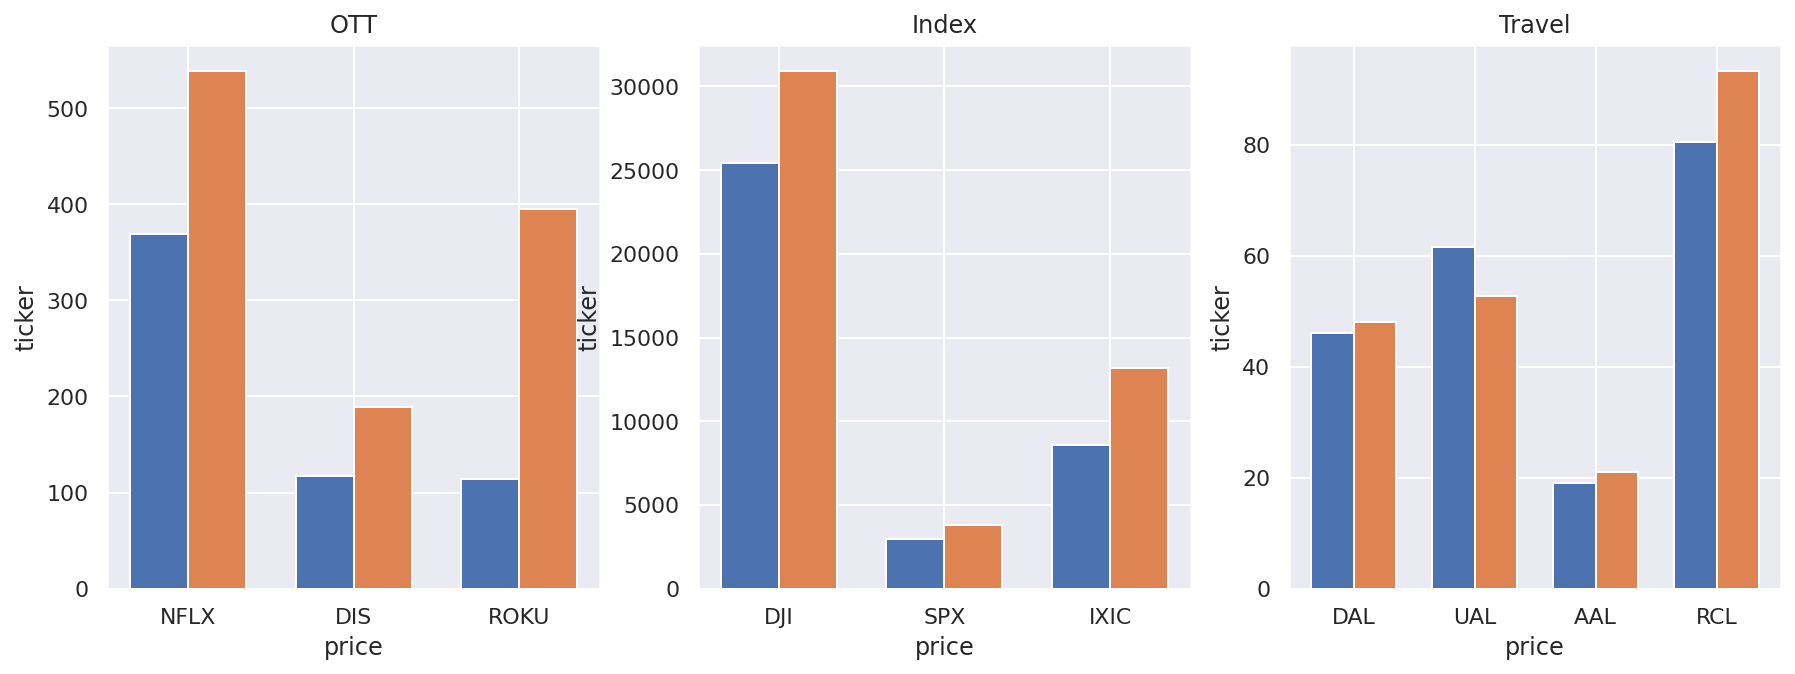

In [41]:
label_OTT = ["NFLX", "DIS", "ROKU"]
label_index = ["DJI", "SPX", "IXIC"]
label_travel = ["DAL", "UAL", "AAL", "RCL"]

index_OTT = np.arange(len(label_OTT))
index_indexes = np.arange(len(label_index))
index_travel = np.arange(len(label_travel))

bar_width = 0.35
alpha = 0

plt.figure(figsize=(15,5))

ax = plt.subplot(1, 3, 1)
ax.bar(index_OTT, stocks_OTT[2020.02], bar_width)
ax.bar(index_OTT + bar_width, stocks_OTT[2021.02], bar_width)
plt.xticks([0.175, 1.175, 2.175], label_OTT)
plt.xlabel('price')
plt.ylabel('ticker')
plt.title("OTT")

plt.subplot(1, 3, 2)
plt.bar(index_indexes, indexes[2020.02], bar_width)
plt.bar(index_indexes + bar_width, indexes[2021.02], bar_width)
plt.xticks([0.175, 1.175, 2.175], label_index)
plt.xlabel('price')
plt.ylabel('ticker')
plt.title("Index")

plt.subplot(1, 3, 3)
plt.bar(index_travel, stocks_travel[2020.02], bar_width)
plt.bar(index_travel + bar_width, stocks_travel[2021.02], bar_width)
plt.xticks([0.175, 1.175, 2.175, 3.175], label_travel)
plt.xlabel('price')
plt.ylabel('ticker')
plt.title("Travel")